In [1]:
import os
import sys
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.text.epu import *

## EPU

In [2]:
target_dir = os.getcwd() + "/outputs/text/png/"

epu_df = pd.DataFrame()
filepaths = [
    os.getcwd() + "/data/text/png/post_courier_news.csv",
    os.getcwd() + "/data/text/abc_au/papua_new_guinea_abc_news.csv",
    os.getcwd() + "/data/text/rnz/papua_new_guinea_rnz_news.csv"
]
for i, nn in zip(filepaths, ["post_courier", "abc_au", "rnz"]):
    epu = EPU(filepath=i)
    epu.get_epu_category()
    temp = epu.get_epu_stats(cutoff="2020-01-01")
    temp.columns = [
        str(nn) + "_" + col if col not in ["date"] else col
        for col in temp.columns
    ]
    if epu_df.empty:
        epu_df = temp
    else:
        epu_df = epu_df.merge(temp, how="outer", on=["date"])

epu_df.head(5)

,date,post_courier_news_count,post_courier_epu_count,post_courier_ratio,post_courier_z_score,abc_au_news_count,abc_au_epu_count,abc_au_ratio,abc_au_z_score,rnz_news_count,rnz_epu_count,rnz_ratio,rnz_z_score
0,2015-12-01,104.0,1.0,0.009615,0.866799,12.0,0.0,0.0,0.0,78.0,0.0,0.000000,0.000000
1,2016-01-01,202.0,2.0,0.009901,0.892546,16.0,0.0,0.0,0.0,72.0,0.0,0.000000,0.000000
2,2016-02-01,195.0,2.0,0.010256,0.924586,9.0,0.0,0.0,0.0,80.0,1.0,0.012500,0.215960
3,2016-03-01,234.0,2.0,0.008547,0.770488,25.0,0.0,0.0,0.0,85.0,2.0,0.023529,0.406513
4,2016-04-01,209.0,3.0,0.014354,1.293978,43.0,0.0,0.0,0.0,87.0,3.0,0.034483,0.595752


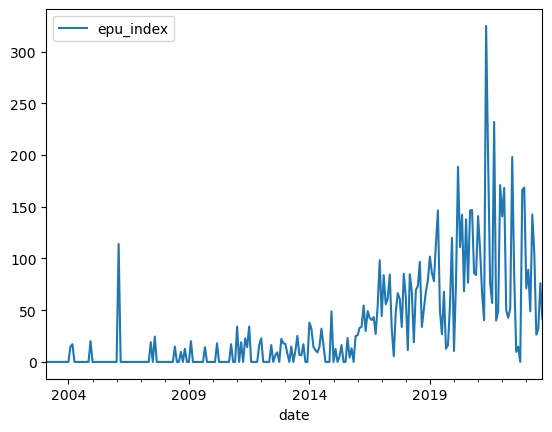

In [3]:
epu_df = epu_df.sort_values(by="date").reset_index(drop=True).fillna(0)
epu_df["z_score"] = epu_df[["abc_au_z_score", "post_courier_z_score", "rnz_z_score"]].mean(axis=1)
scale_factor = 100/epu_df[epu_df.date >= "2020-01-01"]["z_score"].mean()
epu_df["epu_index"] = epu_df["z_score"] * scale_factor
epu_df.plot(x="date", y="epu_index");

In [4]:
if os.path.exists(target_dir):
    epu_df.to_csv(target_dir + "png_epu.csv", encoding="utf-8")

## GUI

In [5]:
from src.google_trends import GT
from dotenv import load_dotenv
load_dotenv()

from bokeh.plotting import figure, show, output_notebook, from_networkx, output_file
from bokeh.models import (Select, HoverTool, TapTool, BoxSelectTool, Legend,
                          Range1d, Circle, MultiLine)
from bokeh.palettes import Category20
import networkx as nx
from src.text.gui import DrawTopics
output_notebook()

Loading BokehJS ...

In [20]:
GoogleAPIkey = os.getenv("GoogleAPIkey")

In [7]:
inflation_words = [
    "inflation", "inflation rate", "CPI", "prices", "food price",
    "price index", "price in port moresby", "port moresby price",
    "price in lae", "lae price"
]


job_words = [
    "job",
    "unemployment",
    "hiring",
    "layoff",
    "job market",
    "job opportunities",
    "job vacancy",
    "job vacancies",
    "job training",
    "job application",
    "unemployment rate",
    "jobs in solomon islands"
    "jobs in port moresby",
    "job in port moresby",
    "job in lae",
    "jobs in lae",
]

In [18]:
target_dir = os.getcwd() + "/outputs/text/png/"
gt = GT(GoogleAPIkey)
for words, name in zip([job_words, inflation_words],
                       ["png_price_graph", "png_job_graph"]):
    dnx = DrawTopics(words, "PG", gt)
    dnx.trends_to_nx_object()
    dnx.result.to_csv(target_dir+name+".csv", encoding="utf-8")
    output_file(filename=target_dir + f"{name}.html")
    p = dnx.make_graph()
    show(p)

job : 0 out of 106 rows with zero values.
unemployment : 28 out of 106 rows with zero values.
hiring : 28 out of 106 rows with zero values.
layoff : 89 out of 106 rows with zero values.
job market : 74 out of 106 rows with zero values.
job opportunities : 18 out of 106 rows with zero values.
job vacancy : 3 out of 106 rows with zero values.
job vacancies : 0 out of 106 rows with zero values.
job training : 35 out of 106 rows with zero values.
job application : 6 out of 106 rows with zero values.
unemployment rate : 63 out of 106 rows with zero values.
jobs in solomon islandsjobs in port moresby : 106 out of 106 rows with zero values.
job in port moresby : 23 out of 106 rows with zero values.
job in lae : 37 out of 106 rows with zero values.
jobs in lae : 67 out of 106 rows with zero values.


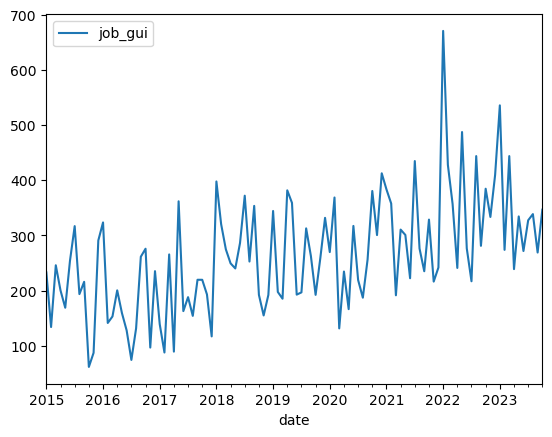

In [9]:
benchmark_term = "government"
geo_iso2 = "PG"
start_time = "2015-01"

benchmark_df = gt.to_df(gt.get_graph(benchmark_term, geo_iso2, start_time))
benchmark_df = benchmark_df.drop("term", axis=1).rename({"value": "benchmark"},
                                                        axis=1)

local_trends_df = pd.DataFrame()
for term in job_words:
    r = gt.get_graph(term, geo_iso2, start_time)
    r_df = gt.to_df(r)
    print(
        f"{term} : {(r_df.value==0).sum()} out of {len(r_df)} rows with zero values."
    )
    r_df = (r_df.drop("term", axis=1).rename({"value": term}, axis=1))

    if local_trends_df.empty:
        local_trends_df = r_df
    else:
        local_trends_df = local_trends_df.merge(r_df, how="left", on="date")

local_trends_df.columns = [
    col.lower().replace(" ", "_") for col in local_trends_df.columns
]

df = local_trends_df.merge(benchmark_df).drop("date", axis=1).fillna(0)

# Benchmark keyword volumes
svi_bt = df["benchmark"] / df["benchmark"].max()
svi_bj = df["benchmark"] / df.max(axis=1)

df["weight"] = (svi_bt / svi_bj).fillna(0)
for i in df.index:
    df.iloc[i, :-4] = df.iloc[i, :-4] * df["weight"][i]
    
df["job_gui"] =  df.iloc[:, :-4].sum(axis=1)

df["date"] = r_df["date"].tolist()
gui = df.set_index("date").groupby(pd.Grouper(freq='MS'))[["job_gui"]].sum().reset_index()
gui.plot(x="date");

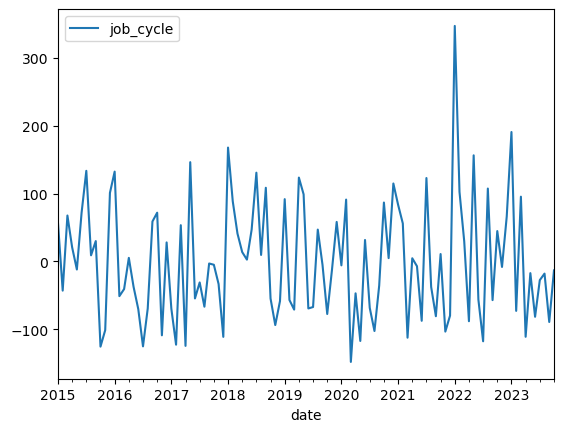

In [10]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(gui["job_gui"], 129600)
gui["job_cycle"] = cycle
gui.plot(x="date", y="job_cycle");
gui.to_csv(target_dir + "png_job_gui.csv", encoding="utf-8")

## Sentiment Analysis

In [11]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from tqdm import tqdm

In [13]:
sid = SentimentIntensityAnalyzer()

news_df = pd.DataFrame()
for name, file in zip(["pc", "abc_au", "rnz"], filepaths):
    df = pd.read_csv(file).drop("Unnamed: 0", axis=1)
    df["date"] = pd.to_datetime(df["date"], utc=False)
    score_df = pd.DataFrame()
    with tqdm(total=len(df)) as pbar:
        for news in df.news:
            news = str(news)
            scores = sid.polarity_scores(news)
            ss_temp = pd.DataFrame(scores, columns=scores.keys(), index=[0])
            if score_df.empty:
                score_df = ss_temp
            else:
                score_df = pd.concat([score_df, ss_temp], axis=0)
            pbar.update(1)
    df["score"] = score_df["compound"].tolist()
    df_sent = (df.set_index("date").groupby(pd.Grouper(freq="MS"))[["score"]].mean().reset_index()
                 .rename({"score": name}, axis=1))
    df_sent["date"] = [pd.to_datetime(d.date()) for d in df_sent.date]
    if news_df.empty:
        news_df = df_sent
    else:
        news_df = news_df.merge(df_sent, how="outer", on="date")

100%|██████████████████████████████████████████████████████████████████████████| 5627/5627 [00:09<00:00, 619.87it/s]


In [17]:
news_df = news_df.sort_values(by="date").reset_index(drop=True).rename({"pc": "post_courier"}, axis=1)
news_df.to_csv(target_dir+"png_sentiment_score_monthly.csv", encoding="utf-8")